In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
from natsort import natsorted
import pickle

In [3]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [0.025, 0.05, 0.1, 0.2],
            [62, 125, 250, 500, 1000],
            np.arange(500),
        )
    ],
    columns=["hsq", "ncausal", "sim_i"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [4]:
result_file = "results/dict_df_res.pkl"
if os.path.exists(result_file):
    with open(result_file, "rb") as f:
        dict_df_res = pickle.load(f)
else:
    dict_df_res = {}

    for group in ["causal", "clump"]:
        df_res = []
        for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
            path = f"out/summary/{param.prefix}.sim_{param.sim_i}.{group}.tsv"
            if os.path.exists(path):
                df_tmp = pd.read_csv(path, sep="\t")
                # perform filtering on the causal df (not done)
                # df_tmp = df_tmp[df_tmp.assoc_p < 5e-8]
                df_tmp["ncausal"] = param.ncausal
                df_tmp["hsq"] = param.hsq
                df_tmp["sim_i"] = param.sim_i
                df_tmp["pos"] = df_tmp.snp.apply(lambda x: int(x.split(":")[1]))
                df_res.append(df_tmp)
        df_res = pd.concat(df_res).reset_index(drop=True)
        # filter for SNPs with super small MAF in either one of the populations
        df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
        print(group, np.mean(df_res.het_pval < 0.05))
        dict_df_res[group] = df_res

    with open(result_file, "wb") as f:
        pickle.dump(dict_df_res, f)

In [5]:
dict_df_res["causal"] = dict_df_res["causal"][dict_df_res["causal"].assoc_p < 5e-8]

In [6]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = EUR, 2nd local ancestry = AFR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [7]:
# n_bootstrap = 9
# sample_size = 70

# np.random.seed(1234)

# dict_df_plot = {}

# for group in ["causal", "clump"]:
#     df_plot = []
#     for i in tqdm(range(n_bootstrap)):
#         df_plot.append(
#             summarize_res(
#                 dict_df_res[group]
#                 .groupby(["ncausal", "hsq"])
#                 .sample(n=sample_size)
#                 .groupby(["ncausal", "hsq"])
#             ).set_index(["ncausal", "hsq"])
#         )
#     df_plot_mean = pd.DataFrame(
#         np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
#     ).reset_index()
#     df_plot_se = pd.DataFrame(
#         np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
#     ).reset_index()
#     dict_df_plot[group] = (df_plot_mean, df_plot_se)

# for group in ["causal", "clump"]:
#     print(group + ":")
#     df_plot_mean, df_plot_se = dict_df_plot[group]
#     display(
#         df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
#         + "±"
#         + df_plot_se.set_index(["ncausal", "hsq"]).round(3).astype(str)
#     )

In [8]:
stratify_by = ["ncausal", "hsq"]
n_bootstrap = 9

np.random.seed(1234)

dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = summarize_res(dict_df_res[group].groupby(stratify_by)).set_index(
        stratify_by
    )

    # standard error
    df_plot_se = []

    for i in tqdm(range(n_bootstrap)):
        df_tmp = (
            summarize_res(
                dict_df_res[group]
                .sample(len(dict_df_res[group]), replace=True)
                .groupby(stratify_by)
            )
            .set_index(stratify_by)
            .reindex(df_plot.index)
        )
        df_plot_se.append(df_tmp)

    df_plot_se = pd.DataFrame(
        np.std(df_plot_se, axis=0),
        index=df_plot.index,
        columns=df_plot.columns,
    )
    df_plot = df_plot.reset_index()
    df_plot_se = df_plot_se.reset_index()
    dict_df_plot[group] = (df_plot, df_plot_se)

for group in ["causal", "clump"]:
    print(group + ":")
    df_plot, df_plot_se = dict_df_plot[group]
    display(
        df_plot.set_index(stratify_by).round(3).astype(str)
        + "±"
        + df_plot_se.set_index(stratify_by).round(3).astype(str)
    )

100%|██████████| 9/9 [01:15<00:00,  8.38s/it]

causal:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
62      0.025   1.323±0.085  0.087±0.008  0.924±0.003    1.015±0.008   
        0.050   1.573±0.049  0.138±0.003  0.904±0.002    1.015±0.006   
        0.100   2.046±0.041  0.181±0.006  0.914±0.003    1.014±0.003   
        0.200   2.657±0.053   0.25±0.003  0.926±0.001    1.006±0.002   
125     0.025   1.275±0.055  0.101±0.013  0.888±0.009    1.004±0.006   
        0.050   1.722±0.055  0.154±0.003  0.892±0.003    1.036±0.007   
        0.100   2.162±0.028  0.198±0.003  0.883±0.002    1.013±0.004   
        0.200   2.991±0.069  0.279±0.005  0.891±0.002     1.02±0.003   
250     0.025   1.456±0.212  0.093±0.014  0.905±0.015    1.044±0.027   
        0.050    1.63±0.069  0.129±0.007  0.881±0.007     1.02±0.008   
        0.100    2.137±0.06  0.205±0.004  0.873±0.005    1.023±0.004   
        0.200   3.483±0.064  0.304±0.002  0.852±0.002    1.043±0.004   
500     0.025   2.105±0.604  0.239±0.047  0.854±0.034     1.02±0.057   
        0.050   1.787±0.147  0.159±0.012  0.872±0.011    1.033±0.017   
        0.100   2.691±0.068  0.246±0.003  0.838±0.004    1.082±0.005   
        0.200   3.492±0.052  0.308±0.003  0.818±0.002     1.05±0.005   
1000    0.025   0.721±0.222  0.062±0.061   0.951±0.02    1.134±0.184   
        0.050   2.267±0.393  0.184±0.019   0.835±0.02     1.05±0.029   
        0.100   3.006±0.145  0.278±0.006  0.817±0.008     1.06±0.011   
        0.200   4.432±0.068  0.361±0.003  0.761±0.002     1.11±0.007   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
62      0.025    0.985±0.007  0.987±0.009  0.865±0.009  
        0.050    0.985±0.005  0.981±0.007  0.833±0.009  
        0.100    0.986±0.003  0.978±0.005  0.855±0.004  
        0.200    0.994±0.002  0.968±0.004  0.886±0.003  
125     0.025    0.996±0.006  0.953±0.011  0.827±0.013  
        0.050    0.966±0.007  0.976±0.012  0.814±0.008  
        0.100    0.987±0.004  0.956±0.005  0.816±0.006  
        0.200     0.98±0.003  0.959±0.003  0.828±0.004  
250     0.025    0.958±0.024  1.004±0.023  0.815±0.023  
        0.050    0.981±0.008  0.962±0.016  0.806±0.014  
        0.100    0.978±0.004  0.949±0.006  0.802±0.007  
        0.200    0.959±0.004  0.939±0.004  0.772±0.003  
500     0.025     0.98±0.056  0.892±0.053  0.818±0.039  
        0.050    0.968±0.016  0.926±0.015  0.822±0.021  
        0.100    0.924±0.004  0.949±0.008   0.74±0.004  
        0.200    0.953±0.004  0.915±0.003  0.731±0.003  
1000    0.025    0.882±0.164  1.113±0.181  0.813±0.128  
        0.050    0.952±0.026  0.935±0.036  0.745±0.025  
        0.100     0.944±0.01  0.911±0.009   0.732±0.01  
        0.200    0.901±0.006  0.891±0.003   0.65±0.004

clump:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
62      0.025   1.215±0.067  0.088±0.007  0.743±0.047    1.016±0.005   
        0.050   1.564±0.042  0.144±0.004  0.779±0.019    1.019±0.005   
        0.100   2.357±0.045  0.236±0.003  0.543±0.011    1.039±0.003   
        0.200   3.729±0.043  0.352±0.002  0.419±0.007    1.084±0.003   
125     0.025   1.301±0.052  0.096±0.007  0.702±0.057     0.995±0.01   
        0.050    1.691±0.04  0.155±0.005  0.722±0.029    1.031±0.009   
        0.100   2.436±0.061   0.23±0.003  0.585±0.013    1.032±0.004   
        0.200   4.012±0.079  0.359±0.003    0.45±0.01    1.101±0.004   
250     0.025   1.257±0.198  0.088±0.017  0.784±0.049     1.02±0.017   
        0.050   1.657±0.069  0.133±0.006  0.744±0.024     1.02±0.007   
        0.100   2.258±0.044  0.216±0.004  0.671±0.017     1.03±0.003   
        0.200   4.127±0.045  0.354±0.002   0.51±0.005    1.088±0.002   
500     0.025    1.702±0.19  0.171±0.019  0.611±0.168    1.065±0.036   
        0.050   1.849±0.112  0.175±0.017  0.664±0.095    1.034±0.012   
        0.100   2.705±0.092  0.249±0.005  0.615±0.028    1.068±0.007   
        0.200   4.161±0.058  0.352±0.002   0.49±0.016    1.093±0.004   
1000    0.025   1.267±0.318  0.114±0.044   0.298±0.32    1.043±0.067   
        0.050   2.063±0.269  0.193±0.025   0.583±0.06    1.062±0.022   
        0.100   3.122±0.172  0.279±0.008   0.53±0.029    1.082±0.011   
        0.200   5.008±0.066  0.396±0.003   0.456±0.01    1.144±0.007   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
62      0.025    0.984±0.005  0.976±0.043  0.566±0.082  
        0.050    0.981±0.005  0.981±0.013  0.618±0.032  
        0.100    0.962±0.003  0.794±0.016  0.371±0.011  
        0.200    0.923±0.002  0.654±0.009  0.268±0.007  
125     0.025    1.005±0.011    0.9±0.033  0.548±0.077  
        0.050     0.97±0.008  0.826±0.067  0.632±0.038  
        0.100    0.969±0.004  0.728±0.018  0.469±0.018  
        0.200    0.909±0.003  0.615±0.014  0.329±0.011  
250     0.025     0.98±0.017  0.968±0.097  0.635±0.041  
        0.050     0.98±0.007  0.935±0.035  0.593±0.044  
        0.100     0.97±0.002  0.797±0.029  0.564±0.023  
        0.200    0.919±0.002  0.667±0.014   0.39±0.011  
500     0.025    0.939±0.029  1.083±0.158  0.345±0.207  
        0.050    0.967±0.011  0.734±0.057  0.601±0.128  
        0.100    0.936±0.007  0.741±0.037   0.511±0.05  
        0.200    0.915±0.003  0.601±0.015   0.399±0.02  
1000    0.025    0.959±0.061  0.595±0.654   0.15±0.164  
        0.050    0.942±0.019    0.674±0.1  0.504±0.047  
        0.100     0.924±0.01  0.625±0.044   0.45±0.041  
        0.200    0.874±0.005  0.547±0.023  0.381±0.019

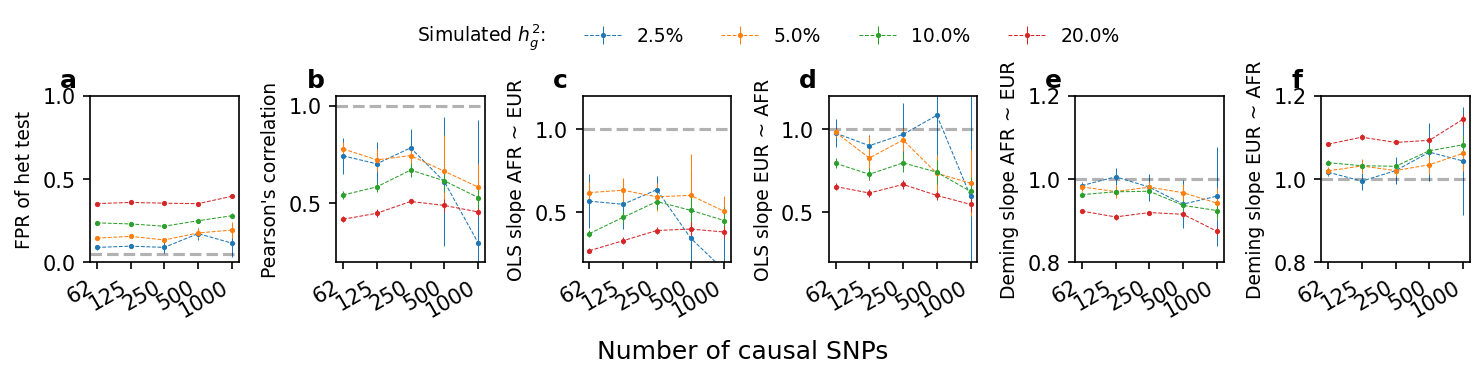

In [9]:
y_var_list = [
    "het_fpr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
    "deming_afr~eur",
    "deming_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Pearson's correlation",
    "OLS slope AFR ~ EUR",
    "OLS slope EUR ~ AFR",
    "Deming slope AFR ~ EUR",
    "Deming slope EUR ~ AFR",
]
dict_ylim = {
    "het_fpr": [0, 1.0],
    "pearsonr": [0.2, 1.05],
    "ols_afr~eur": [0.2, 1.2],
    "ols_eur~afr": [0.2, 1.2],
    "deming_afr~eur": [0.8, 1.2],
    "deming_eur~afr": [0.8, 1.2],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}
# "Pearson's correlation" is not plotted because i don't think it makes sense

fig, axes = plt.subplots(figsize=(10, 2), ncols=len(y_var_list), nrows=1, dpi=150)
axes = axes.flatten()

# for each panel
for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
    ax = axes[i]
    for hsq in df_plot.hsq.unique():
        df_est_tmp = df_plot[df_plot.hsq == hsq]
        df_se_tmp = df_plot_se[df_plot_se.hsq == hsq]
        ax.errorbar(
            np.arange(len(df_est_tmp.ncausal)),
            df_est_tmp[y_var],
            yerr=df_se_tmp[y_var] * 1.96,
            fmt=".--",
            ms=3,
            mew=1,
            label=f"{hsq * 100}%",
            linewidth=0.5,
        )

    ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
    ax.set_xticks(np.arange(len(df_est_tmp.ncausal)))
    ax.set_xticklabels(df_est_tmp.ncausal, rotation=30, ha="right")
    ax.set_ylabel(y_label, fontsize=9)
    ax.set_ylim(dict_ylim[y_var])

    # annotation
    ax.text(
        -0.2,
        1.05,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.05,
    "Number of causal SNPs",
    fontsize=12,
    ha="center",
)


plt.tight_layout()
plt.show()

# Main figure

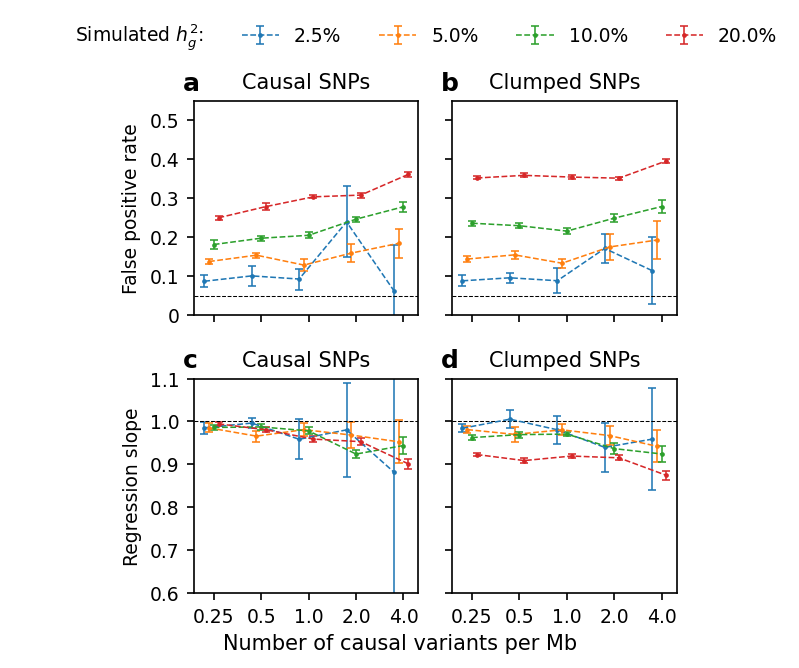

In [10]:
yvar_list = [
    "het_fpr",
    "deming_afr~eur",
]
dict_ylabel = {
    "het_fpr": "False positive rate",
    "deming_afr~eur": "Regression slope",
}
dict_ylim = {
    "het_fpr": [0, 0.55],
    "deming_afr~eur": [0.6, 1.1],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "deming_afr~eur": [0.6, 0.7, 0.8, 0.9, 1.0, 1.1],
}
fig, axes = plt.subplots(
    figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
)
for group_i, group in enumerate(["causal", "clump"]):
    df_plot, df_plot_se = dict_df_plot[group]
    for yvar_i, yvar in enumerate(yvar_list):
        ax = axes[yvar_i, group_i]
        for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
            df_est_tmp = df_plot[df_plot.hsq == hsq]
            df_se_tmp = df_plot_se[df_plot_se.hsq == hsq]
            ax.errorbar(
                np.arange(len(df_est_tmp.ncausal)) + (hsq_i - 2) * 0.1,
                df_est_tmp[yvar],
                yerr=df_se_tmp[yvar] * 1.96,
                fmt=".--",
                label=f"{hsq * 100}%",
                ms=3,
                linewidth=0.75,
                mew=0.75,
                capsize=2,
            )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
        ax.set_xticks(np.arange(len(df_est_tmp.ncausal)))
        ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
        if group_i == 0:
            ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_ylim(dict_ylim[yvar])

        if group == "causal":
            ax.set_title("Causal SNPs", fontsize=10)
        elif group == "clump":
            ax.set_title("Clumped SNPs", fontsize=10)

        # annotation
        ax.text(
            -0.05,
            1.05,
            string.ascii_lowercase[yvar_i * 2 + group_i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.0,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)


plt.tight_layout()
# fig.savefig("chrom-simulation.pdf", bbox_inches="tight")
plt.show()